In [1]:
## Importing libraries
import time
import warnings

import eli5
import shap

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")
%matplotlib inline


import optuna
from optuna.integration import LightGBMPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

import plotly.express as px
from catboost import CatBoostRegressor, Pool
from lightgbm import DaskLGBMRegressor, LGBMRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    RobustScaler,
)
from xgboost import DMatrix, XGBRegressor

SEED = 42
import random

pd.set_option("display.max_columns", 679)
random.seed(SEED)

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/balde/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading the data

In [2]:
train = pd.read_csv("Train.csv")

test = pd.read_csv("Test.csv")
sub = pd.read_csv("SampleSubmission (1).csv")
vard = pd.read_csv("VariableDescription.csv")

In [3]:
train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_except

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8585 entries, 0 to 8584
Columns: 679 entries, child_id to target
dtypes: float64(160), object(519)
memory usage: 44.5+ MB


In [5]:
df_train = train.copy()
df_test = test.copy()

In [6]:
def drop_missing_cols(df, threshold=0.6):
    """
    Drops columns from a pandas dataframe that have more than a specified percentage of missing values.

    Parameters:
    df (pandas.DataFrame): The dataframe to process
    threshold (float): The maximum percentage of missing values a column can have before it is dropped. Default is 0.6.

    Returns:
    pandas.DataFrame: The processed dataframe with dropped columns.
    """
    # Calculate the percentage of missing values in each column
    missing_percent = df.isnull().sum() / len(df)

    # Get a boolean mask of columns with more than the specified threshold of missing values
    drop_cols_mask = missing_percent > threshold

    # Get a list of columns to drop
    drop_cols = df.columns[drop_cols_mask]

    # Drop the columns and return the resulting dataframe
    return df.drop(drop_cols, axis=1)

In [7]:
# df_train = drop_missing_cols(df_train)
# df_test = drop_missing_cols(df_test)

# Encdoing categorical variable

In [8]:
# Here I am going to use LabelEncoder for certain columns and map with other columns.
le = LabelEncoder()

In [9]:
# train.columns[train.columns.str.contains("observe")].to_list()
observe_columns = [
    "child_observe_attentive",
    "child_observe_concentrated",
    "child_observe_diligent",
    "child_observe_interested",
]

mapper_observe = {"Sometimes": 1, "Almost never": 0, "Often": 2, "Almost always": 3}

In [10]:
social_columns = [
    "teacher_social_initiative",
    "teacher_social_peers",
    "teacher_social_nonaggressive",
    "teacher_social_cooperate",
    "teacher_social_assistance",
    "teacher_social_ideas",
    "teacher_social_initiative",
]

mapper_social = {
    "None of the time": 0,
    "A little of the time": 1,
    "Most of the time": 2,
    "All of the time": 3,
}

In [11]:
# Function to map values to the columns
def mapper(df, map_columns, map_values):
    for col in map_columns:
        df[col] = df[col].map(map_values)
    return df

In [12]:
# Mapping values
df_train = mapper(df_train, observe_columns, mapper_observe)
df_test = mapper(df_test, observe_columns, mapper_observe)

df_train = mapper(df_train, social_columns, mapper_social)
df_test = mapper(df_test, social_columns, mapper_social)

## Adding features 

In [13]:
df_train["child_gender"] = df_train["child_gender"].map({"male": 1, "female": 0})
df_test["child_gender"] = df_test["child_gender"].map({"male": 1, "female": 0})

In [14]:
df_train["pre_covid"] = le.fit_transform(df_train["pre_covid"])
df_test["pre_covid"] = le.fit_transform(df_test["pre_covid"])

In [15]:
df_train["language_child"] = le.fit_transform(df_train["language_child"])
df_test["language_child"] = le.fit_transform(df_test["language_child"])

In [16]:
df_train["child_years_in_programme"].value_counts()

1st year in the programme    4369
2nd year in programme        1917
3rd year in programme        1485
Do Not Know                   108
Name: child_years_in_programme, dtype: int64

In [17]:
## =========> END===========>

In [18]:
df_train.columns[df_train.columns.str.contains("child")]

Index(['child_id', 'child_date', 'child_age', 'child_enrolment_date',
       'child_months_enrolment', 'child_grant', 'child_years_in_programme',
       'child_height', 'child_observe_attentive', 'child_observe_concentrated',
       'child_observe_diligent', 'child_observe_interested',
       'child_observe_total', 'child_gender', 'child_dob', 'child_zha',
       'child_stunted', 'child_attends', 'child_attendance', 'child_languages',
       'child_age_group', 'pri_children_4_6_years', 'obs_toilets_children',
       'count_children_present', 'count_children_attendance',
       'count_children_precovid', 'count_toilets_children', 'language_child'],
      dtype='object')

In [19]:
map_years = {
    "1st year in the programme": 1,
    "2nd year in programme": 2,
    "3rd year in programme": 3,
    "Do Not Know": 0,
}

df_train["child_years_in_programme"] = df_train["child_years_in_programme"].map(
    map_years
)
df_test["child_years_in_programme"] = df_test["child_years_in_programme"].map(map_years)

In [20]:
df_train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_except

In [21]:
drop_cols = [
    "count_staff_gender_other",
    "pri_days",
    "obs_lighting_8",
    "count_practitioners_all",
    "count_register_gender_other",
    "obs_heating_3",
    "obs_lighting_5",
    "pri_difficult_see",
    "pri_difficult_walk",
    "obs_lighting_6",
    "teacher_social_initiative",
]
df_train[drop_cols].isnull().sum()

count_staff_gender_other       3424
pri_days                       3394
obs_lighting_8                 6330
count_practitioners_all        6957
count_register_gender_other    3470
obs_heating_3                  6324
obs_lighting_5                 6330
pri_difficult_see              6957
pri_difficult_walk             6957
obs_lighting_6                 6330
teacher_social_initiative      8585
dtype: int64

In [22]:
len(df_train.query("child_gender == 'Female'"))

0

In [23]:
# df_train["child_gender"] = df_child["child_gender"].map({"Male": })

In [24]:
# pd.set_option("display.max_rows", 50)
# df_train["child_dob"] =
# df_train["child_dob"] = pd.to_datetime(df_train["child_dob"],yearfirst=True)
# df_test["child_dob"] = pd.to_datetime(df_test["child_dob"],yearfirst=True)

# df_train["child_dob_month"] = df_train["child_dob"].dt.month
# df_test["child_dob_month"] = df_test["child_dob"].dt.month

# Machine Learning Algorithms

## Training with numerical columns only

In [25]:
n_splits = 10

kf = KFold(n_splits, shuffle=True, random_state=42)
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=42)

In [26]:
# # Cross validation
def cross_validation(X, y, model, cv_method):
    rmse_scores = list()

    # cv = cv_method(n_splits = N_SPLITS, n_repeats=5, random_state=1121218)

    for idx, (train_idx, test_idx) in enumerate(cv_method.split(X, y)):

        print("=" * 12 + f"Training fold {idx}" + 12 * "=")
        start = time.time()

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Making eval_set
        eval_set = [(X_test.values, y_test)]

        # Fitting the model to the data
        model.fit(X_train.values, y_train)

        # Predictions
        preds = model.predict(X_test)

        # Loss
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_scores.append(rmse)

        runtime = time.time() - start

        print(f"Fold {idx} finished with score: {rmse:.5f} in {runtime:.2f} seconds.\n")

    print(f"Average score {np.mean(rmse_scores)}")

    return np.mean(rmse_scores), rmse_scores


# rmse, cv_scores = cross_validation(X, y, hgbr, k_fold)

In [27]:
# Getting feature importances
def get_feature_imp(model, imp_factor):
    cols_imp = [
        (col, imp)
        for col, imp in zip(model.feature_name_, model.feature_importances_)
        if imp < imp_factor
    ]
    cols = [
        col
        for col, imp in zip(model.feature_name_, model.feature_importances_)
        if imp < imp_factor
    ]

    return cols, cols_imp

In [28]:
def feature_imp_dataframe(model):
    feature_imp = model.feature_importances_
    columns = model.feature_name_

    df_imp = pd.DataFrame({"features": columns, "feature_importance": feature_imp})

    df_imp.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    df_imp.reset_index(drop=True, inplace=True)

    return df_imp

In [29]:
def plot_feature_importance(df_feature_imp, n_imp_cols):
    labels = df_feature_imp.iloc[:30, 0].values

    plt.figure(figsize=(20, 6))
    ax = df_feature_imp.iloc[:30, 1].plot(kind="bar", title="Feature Importance")
    ax.set_xticklabels(labels)
    plt.show()

### Selecting numerical columns from df_train and df_test

### Lightgbm

In [30]:
cols_list_2 = [
    "pri_difficult_see",
    "count_staff_contract_substitute",
    "pri_difficult_walk",
    "obs_lighting_4",
    "obs_heating_3",
    "count_register_gender_other",
    "count_staff_paid_managers",
    "obs_lighting_5",
    "count_practitioners_all",
    "obs_cooking_4",
    "pri_days",
    "count_staff_gender_other",
    "obs_cooking_5",
    "obs_lighting_6",
    "obs_lighting_3",
]

cols_list_3 = [
    "pri_difficult_see",
    "count_staff_contract_substitute",
    "pri_difficult_walk",
    "obs_lighting_4",
    "obs_heating_3",
    "count_register_gender_other",
    "count_staff_paid_managers",
    "obs_lighting_5",
    "count_practitioners_all",
    "obs_cooking_4",
    "pri_days",
    "count_staff_gender_other",
    "obs_cooking_5",
    "obs_lighting_6",
    "obs_lighting_3",
    "language_match",
    "teacher_social_initiative",
    "obs_lighting_8",
    "obs_heating_7",
]

In [31]:
train_int_cols = df_train.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns
test_int_cols = df_test.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns

# Numerical columns
num_cols = list(set(test_int_cols).intersection(set(train_int_cols)))


X, y = df_train[num_cols].drop(columns=drop_cols), df_train[["target"]]
# X, y = df_train[num_cols].drop(columns=cols_list_2), df_train[['target']]
# X, y = df_train[num_cols].drop(columns=cols_list_3), df_train[['target']]

# Selecting the features for test-data
# Prediction on test set
test_data = df_test[X.columns.to_list()]

In [32]:
X.shape, y.shape

((8585, 162), (8585, 1))

In [33]:
X.head()

,pqa_score_environment,count_register_year_school,pri_expense_food,count_staff_paid_cooks,obs_heating_6,pqa_score_curriculum,count_staff_time_part,count_register_all,teacher_social_nonaggressive,id_ward_n,opening_hours,obs_classrooms,id_mn_n,pri_capacity,obs_heating_7,count_staff_gender,longitude,pra_hhsize,pri_time_open_hours,child_observe_diligent,count_register_gender,count_register_year_2014,teacher_social_total,count_staff_time_full,obs_cooking_6,obs_cooking_4,obs_cooking_3,pqa_score_teaching,pri_covid_staff_retrench,count_register_race,pri_fees_amount_pv,id_enumerator,count_children_attendance,child_height,pri_difficult_hear,count_staff_contract,pri_time_close_hours,teacher_social_peers,pra_class_attendance_precovid,count_practitioners_age_1,obs_heating_1,obs_heating_4,count_practitioners_age_2,count_staff_contract_temporary,pra_class_present,id_facility,pra_class_space,pri_fees_amount_4_6,count_practitioners_age_5,pri_funding_subsidy,count_staff_paid_practitioners,count_staff_all,count_staff_salary,count_register_race_indian,teacher_social_assistance,data_year,sanitation_educators,count_register_year_2019,pri_difficult_hold,child_observe_total,pra_experience,pra_measure_rectangle_width,pre_covid,pri_difficult_learn,count_staff_contract_substitute,count_practitioners_age_6,count_practitioners_age_3,pri_difficult_communicate,child_observe_interested,count_present_boys,count_staff_paid_maintenance,quintile,child_zha,child_months_enrolment,count_register_year_grader,count_toilets_adults,count_staff_time,count_staff_salary_unpaid,child_observe_concentrated,pri_fees_amount_2_3,pri_expense_materials,pri_expense_staff,pri_dsd_year,count_staff_gender_female,pri_amount_funding_dsd,count_children_precovid,obs_lighting_4,teacher_emotional_total,obs_lighting_1,teacher_duration,ses_proxy,pri_expense_rent,count_register_race_african,count_register_race_coloured,pra_class_size,id_team,id_prov_n,count_present_girls,id_dc_n,pri_amount_funding_fees,obs_lighting_3,count_register_race_white,count_register_gender_female,child_observe_attentive,ward_best,teacher_selfcare_total,latitude,count_register_foreign,count_staff_paid_support,language_child,obs_heating_2,child_years_in_programme,count_staff_qual_nqf6_9,count_staff_qual_nqf4_5,pqa_score_assessment,count_staff_qual_skills,language_match,count_register_year_2018,child_gender,pri_fees_amount_0_1,count_staff_gender_male,count_register_gender_male,pri_expense_maintenance,count_children_present,count_register_year_2021,count_staff_paid_assistants,pri_clinic_time,obs_lighting_2,obs_cooking_1,count_register_race_other,count_staff_salary_paid,count_register_year_2013,pqa_score_relationships,count_register_year_2016,child_age,count_staff_paid_managers,teacher_social_cooperate,pqa_class_assistants,obs_heating_5,pri_children_4_6_years,pri_fees_amount,teacher_social_ideas,obs_cooking_5,count_practitioners_age_0,obs_cooking_2,count_register_year_2020,count_register_year_2015,count_staff_contract_permanent,child_attendance,count_register_year_2017,count_staff_paid,pra_measure_rectangle_length,pri_year,count_practitioners_age_4,pri_expense_admin,pri_expense_other,id_facility_n,pri_time_open_minutes,pri_time_close_minutes,pra_class_attendance,id_ward,count_toilets_children
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,14.0,NaN,NaN,107.0,NaN,NaN,NaN,27.879824,NaN,NaN,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,761.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,1051.0,NaN,134.0,NaN,NaN,NaN,NaN,1,39.0,NaN,-26.551048,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,74201039.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Capturing NaN per row and making a new feature

In [34]:
def feature_engineering(df):
    df["NaN_row"] = df.isna().sum(axis=1)
    df["std"] = df.std(axis=1)
    return df


X = feature_engineering(X)
test_data = feature_engineering(test_data)

# Filling missing values

In [35]:
# pipeline = Pipeline(
#     [
#         ("impute", SimpleImputer()),
#         ("scale", RobustScaler())
#         # ('quantiletransform', QuantileTransformer(random_state=seed))
#     ]
# )

# X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
# test_data = pd.DataFrame(columns=test_data.columns, data=pipeline.transform(test_data))

<AxesSubplot:>

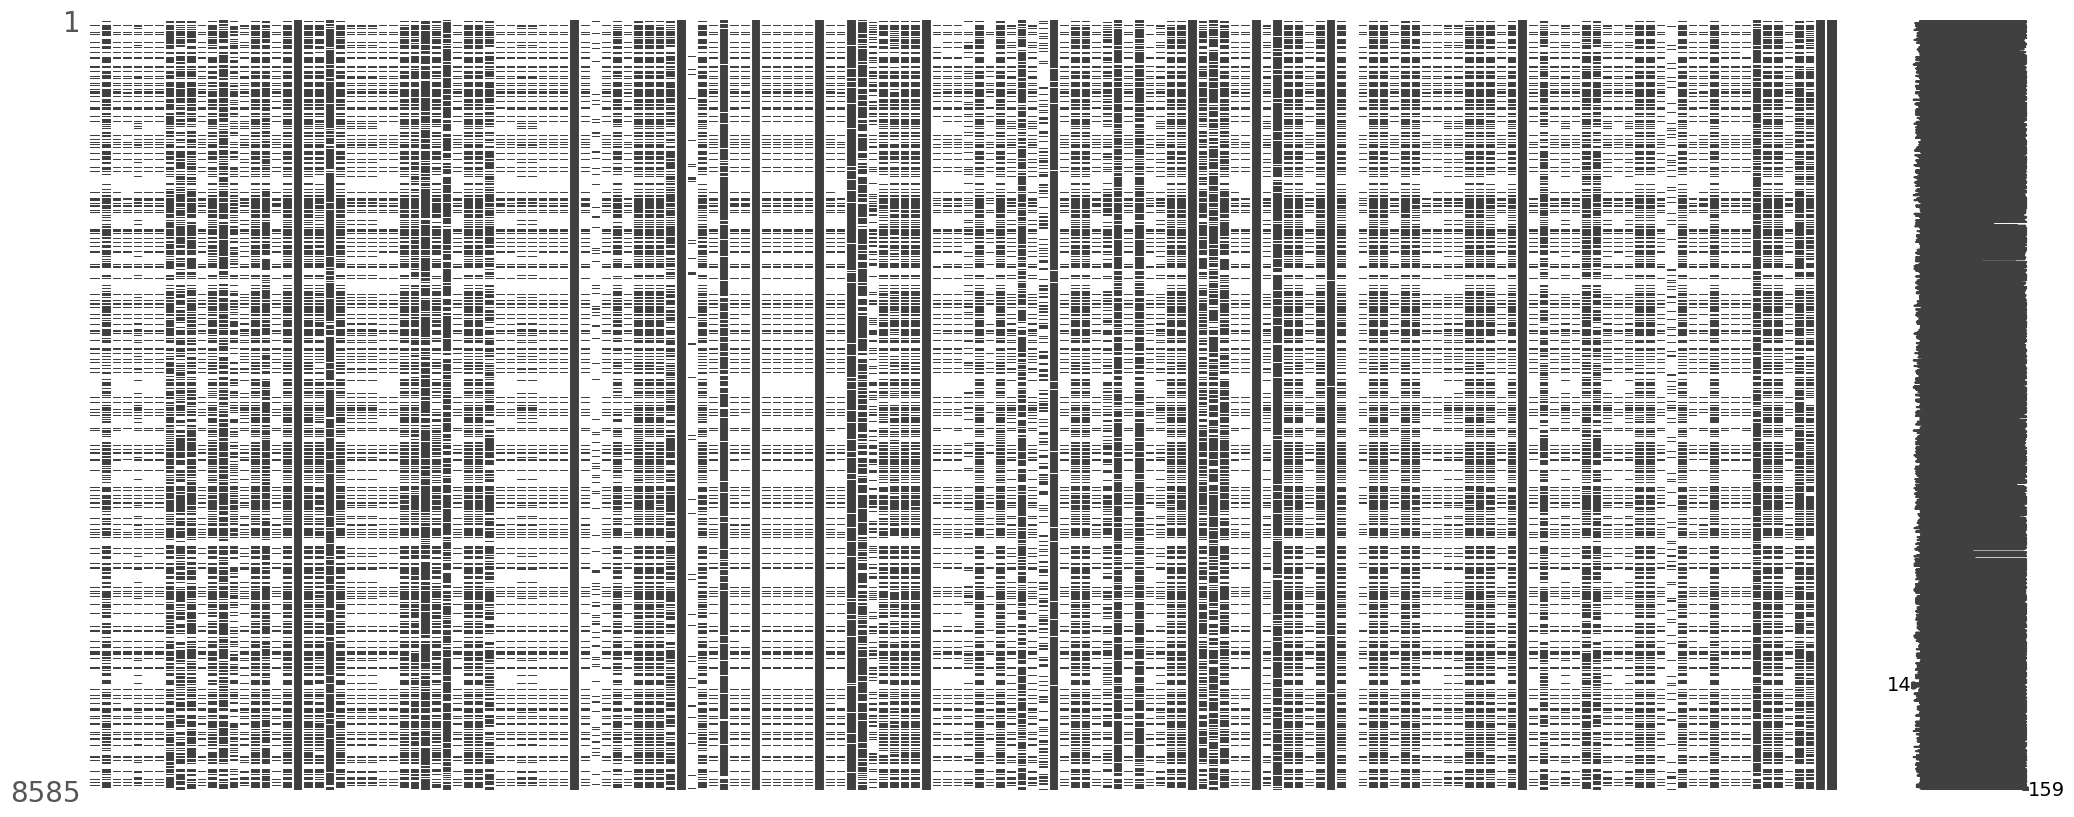

In [36]:
mn.matrix(X)

In [37]:
X.shape, test_data.shape

((8585, 164), (3680, 164))

In [38]:
(X.var()[:-50])

pqa_score_environment         8.855409e+00
count_register_year_school    1.015446e+00
pri_expense_food              4.728289e+07
count_staff_paid_cooks        2.971387e-01
obs_heating_6                 2.542496e-02
                                  ...     
language_child                1.721771e+01
obs_heating_2                 2.296302e-01
child_years_in_programme      6.430950e-01
count_staff_qual_nqf6_9       8.777557e-01
count_staff_qual_nqf4_5       3.766692e+00
Length: 114, dtype: float64

In [39]:
params = {
    "learning_rate": 0.01,
    # "objective": "regression",
    "objective": "tweedie",
    "n_estimators": 6000,
    "num_leaves": 35,
    "max_bin": 240,
    "colsample_bytree": 0.3,
    "max_depth": 7,
    "min_child_samples": 20,
    "random_state": 42,
}

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.03, random_state=55
)

# Training the model with reduced columns
lgbm = LGBMRegressor(**params)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    early_stopping_rounds=100,
    verbose=False,
)

# Get score
lgbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 10.048760144022886),
                          ('tweedie', 27.756582943472065)])})

In [41]:
get_feature_imp(lgbm, 5)

(['count_staff_contract_substitute', 'obs_lighting_3', 'child_gender'],
 [('count_staff_contract_substitute', 4),
  ('obs_lighting_3', 3),
  ('child_gender', 0)])

In [42]:
# Training the model on whole dataset
lgbm = LGBMRegressor(**params)
lgbm.fit(X, y)

LGBMRegressor(colsample_bytree=0.3, learning_rate=0.01, max_bin=240,
              max_depth=7, n_estimators=6000, num_leaves=35,
              objective='tweedie', random_state=42)

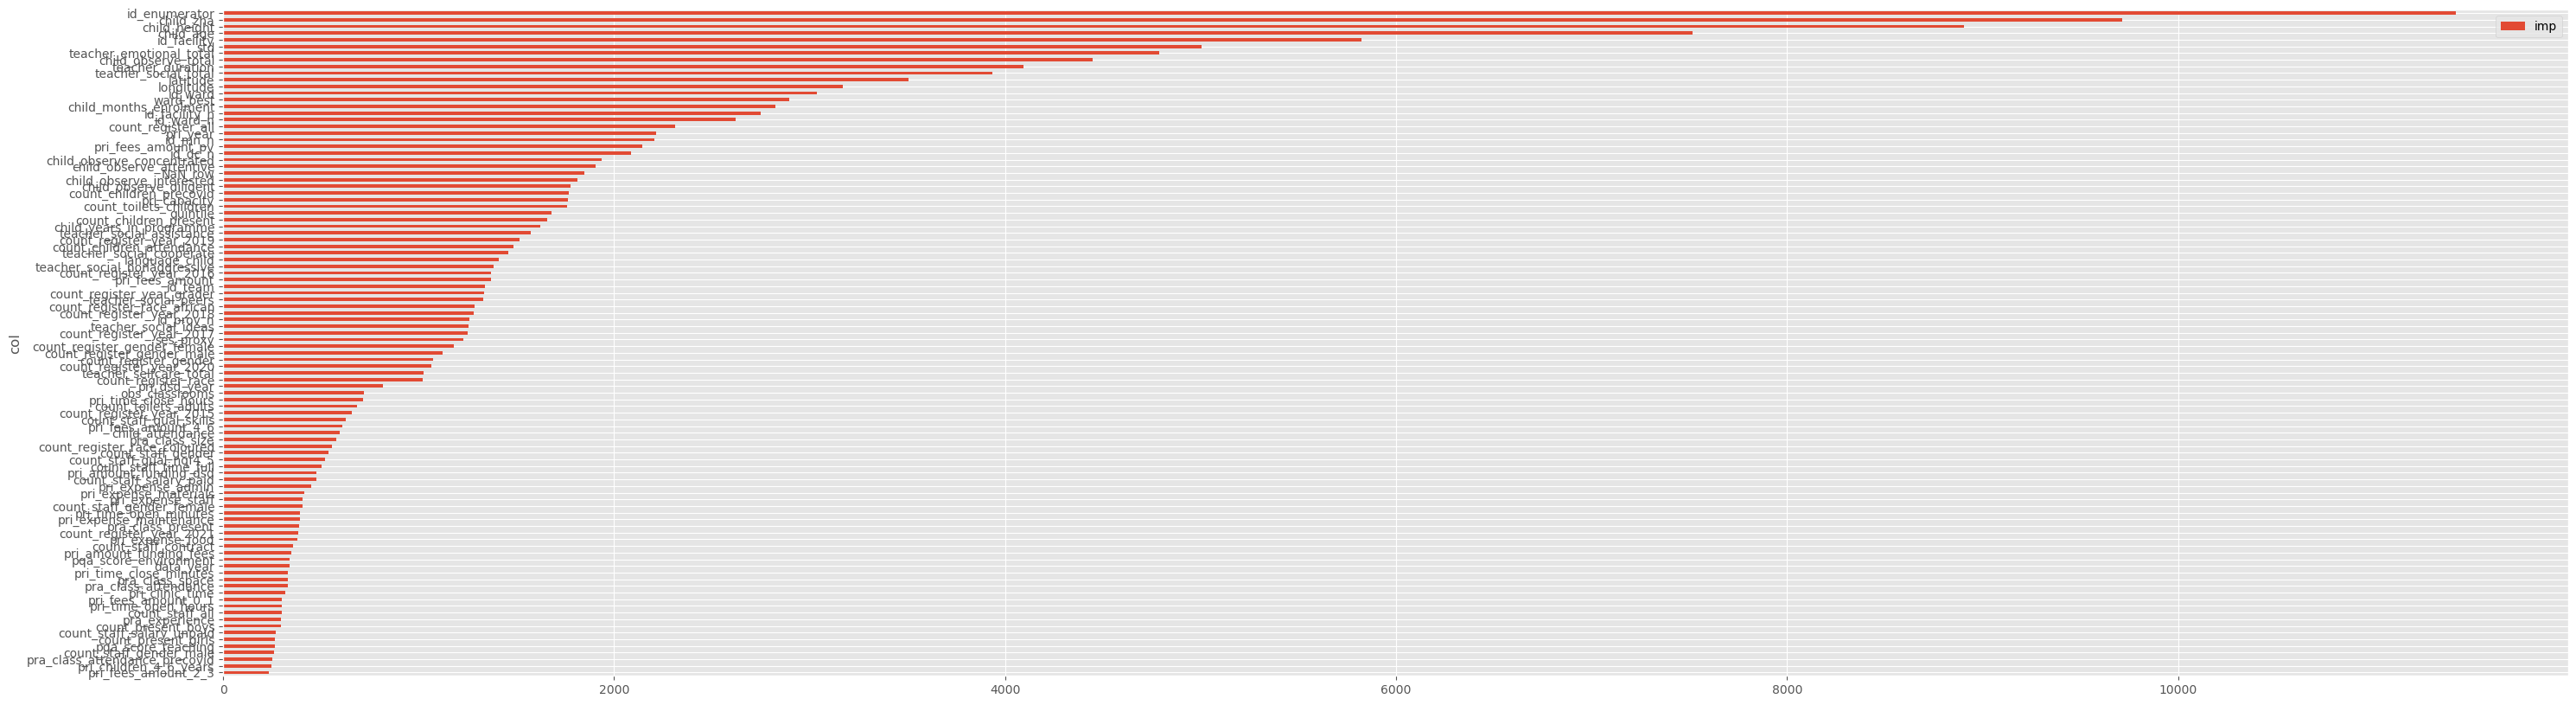

In [43]:
fea_imp = pd.DataFrame({"imp": lgbm.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=True).iloc[-100:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(35, 10))
plt.savefig("catboost_feature_importance.png")

In [44]:
# Prediction on test set
# test_data = df_test[X.columns.to_list()]

preds = lgbm.predict(test_data)
preds

array([60.44234775, 45.61844327, 45.05768226, ..., 36.44256113,
       42.79669568, 42.2443941 ])

In [45]:
# Creating a submissionfile
sub_file = pd.read_csv("GBRSubmission1_score_10.63.csv")
sub_file.target = preds
sub_file.to_csv("LGBMSubmission_drop_cols_4.csv", index=False)

In [46]:
# rmse, cv_scores = cross_validation(X, y, lgbm, kf)

In [47]:
len(preds)

3680

In [48]:
len(test_data)

3680

In [49]:
ooooodklk

NameError: name 'ooooodklk' is not defined

In [ ]:
import optuna
from sklearn.model_selection import train_test_split


def objective(trial, data=X, target=y):

    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.2, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": 42,
        # "n_estimators": 20000,
        "n_estimators": trial.suggest_int("n_estimators", 100, 100_000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.001, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04, 0.05]
        ),
        "max_depth": trial.suggest_categorical(
            "max_depth",
            [
                6,
                7,
                8,
                8,
                10,
                11,
                13,
                14,
                15,
                20,
            ],
        ),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("min_data_per_groups", 1, 100),
    }
    model = LGBMRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)